# Où sont les ménages défavorisés ?

In [117]:
!pip install -q -q -q geopandas
!pip install -q -q -q py7zr
!pip install -q -q -q btbpy
!pip install -q -q -q mapclassify
!pip install -q -q -q contextily

In [214]:
import os
import urllib.request
import shutil
from py7zr import unpack_7zarchive

import pandas as pd
import geopandas as gpd
import btbpy as btb
import contextily as cx

import matplotlib.pyplot as plt

Load the whole french grid (1km)

In [16]:
chem_data_dir = os.path.join(os.path.dirname(btb.__file__),'data')
chem_data_grid = os.path.join(chem_data_dir, 'fr_metro_grid1km.csv')
fr_1km = pd.read_csv(chem_data_grid) #the grid

Load French communes and create departement and region layers

In [38]:
shutil.unpack_archive('commune_francemetro_2020_simplify.zip')

In [42]:
commune = gpd.read_file('commune_francemetro_2020.shp')

In [46]:
departement = commune.dissolve('dep', as_index=False)
region = commune.dissolve('reg', as_index=False)

Download and load the french data grid

In [5]:
url = 'https://www.insee.fr/fr/statistiques/fichier/4176290/Filosofi2015_carreaux_200m_shp.zip'
urllib.request.urlretrieve(url, 'sdf.zip')
shutil.unpack_archive('sdf.zip')
shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)
shutil.unpack_archive('Filosofi2015_carreaux_200m_metropole_shp.7z', '')

In [6]:
sdf = gpd.read_file('Filosofi2015_carreaux_200m_metropole.shp')

In [288]:
Men = sdf[['IdINSPIRE','geometry', 'Depcom', 'Men', 'Men_pauv', 'Ind_snv', 'Ind']].copy()
Men['x'] = Men.geometry.centroid.x
Men['y'] = Men.geometry.centroid.y

## Analyse classique 

Dans cette première partie, on explore la répartion des ménages pauvres à l'aide d'un ratio relativement naturel : la part des ménages pauvre parmi l'ensemble des ménages. Les données carroyées sont par construction lacunaire. Il est préférable d'utiliser un lissage spatiale pour faire ressortir l'informartion pertinente.

### France entière

In [25]:
liss_france = btb.kernelSmoothing(Men[['Men', 'Men_pauv', 'x', 'y']], '2154', 1000, 20000, fr_1km,verbose=False)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [72]:
liss_france['ratio_pauvre'] = liss_france.Men_pauv / liss_france.Men * 100

Text(0.5, 1, 'Part des ménages Pauvres (Filosofi 2015) - Rayon de lissage = 20000')

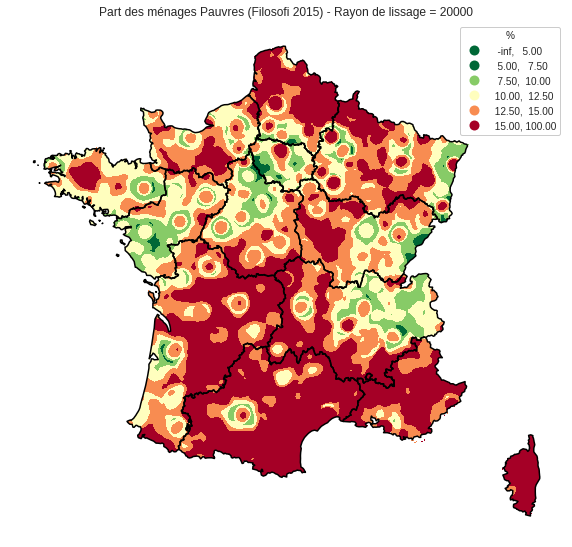

In [271]:
bins = [5, 7.5, 10, 12.5, 15, 100]
ax = liss_france.plot('ratio_pauvre', 
                      scheme='user_defined', 
                      classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'RdYlGn_r', 
                      legend=True,
                      legend_kwds={'loc': 'best', 'frameon':True, 'framealpha':1, 'title':'%'})
region.geometry.boundary.plot(color="black", ax=ax)
ax.set_axis_off()
ax.set_title('Part des ménages Pauvres (Filosofi 2015) - Rayon de lissage = 20000')

### Paris et sa banlieue

In [289]:
Men_Paris = Men.cx[(651935.49-60000):(651935.49+60000),(6862339.24-60000):(6862339.24+60000)]

In [91]:
liss_Paris_extra = btb.kernelSmoothing(Men_Paris[['Men', 'Men_pauv', 'x', 'y']], '2154', 500, 5000,verbose=False)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [92]:
liss_Paris_extra['ratio_pauvre'] = liss_Paris_extra.Men_pauv / liss_Paris_extra.Men * 100

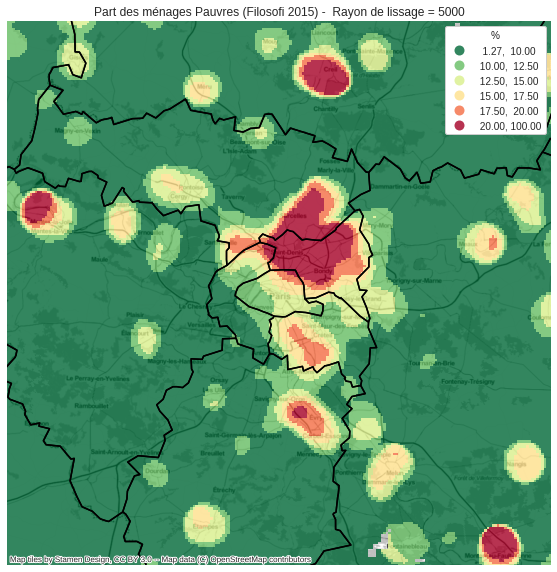

In [270]:
bins = [10, 12.5, 15, 17.5, 20, 100]
ax = liss_Paris_extra.plot('ratio_pauvre', 
                      scheme='user_defined', 
                      classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'RdYlGn_r', 
                      legend=True,
                      alpha=0.8,
                      legend_kwds={'loc': 'best', 'frameon':True, 'framealpha':1, 'title':'%'})
departement.geometry.boundary.plot(color="black", ax=ax)
ax.set_axis_off()
ax.set_xlim((651935-55000, 651935+55000))
ax.set_ylim((6862339-55000, 6862339+55000))
ax.set_title('Part des ménages Pauvres (Filosofi 2015) -  Rayon de lissage = 5000')
cx.add_basemap(ax, crs=liss_Paris_extra.crs.to_string(),source=cx.providers.Stamen.Toner)

### Paris

In [290]:
Men_Paris_intra = Men_Paris.cx[(651935.49-20000):(651935.49+25000),(6862339.24-20000):(6862339.24+20000)]

In [292]:
liss_Paris_intra = btb.kernelSmoothing(Men_Paris_intra[['Men', 'Men_pauv', 'x', 'y', 'Ind_snv', 'Ind']], '2154', 100, 400,verbose=False)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [293]:
liss_Paris_intra['ratio_pauvre'] = liss_Paris_intra.Men_pauv / liss_Paris_intra.Men * 100

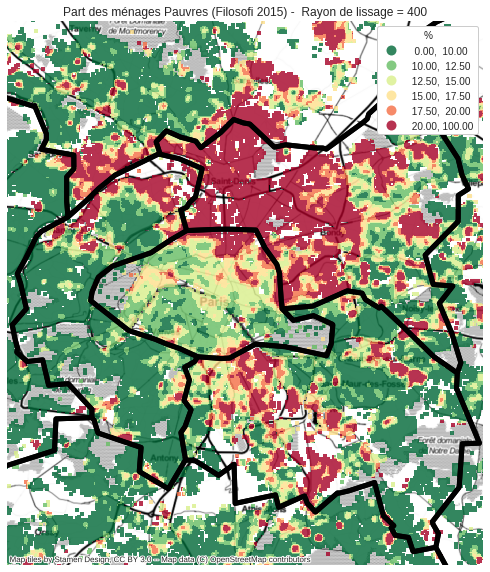

In [272]:
bins = [10, 12.5, 15, 17.5, 20, 100]
ax = liss_Paris_intra.plot('ratio_pauvre', 
                      scheme='user_defined', 
                      classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'RdYlGn_r', 
                      legend=True, 
                      alpha=0.8,
                      legend_kwds={'loc': 'best', 'frameon':True, 'framealpha':1, 'title':'%'})
departement.geometry.boundary.plot(color="black", ax=ax, linewidth=5)
ax.set_axis_off()
ax.set_xlim((651935-15000, 651935+20000))
ax.set_ylim((6862339-20000, 6862339+20000))
ax.set_title('Part des ménages Pauvres (Filosofi 2015) -  Rayon de lissage = 400')
cx.add_basemap(ax, crs=liss_Paris_intra.crs.to_string(),source=cx.providers.Stamen.Toner)

## Analyse en dense (Volume)

Avec des représentations en carte de densité,  la répartition des ménages pauvres est tout autre. 

### France entière

Text(0.5, 1, 'Densité de ménages Pauvres (Filosofi 2015) - Bandwidth = 20000')

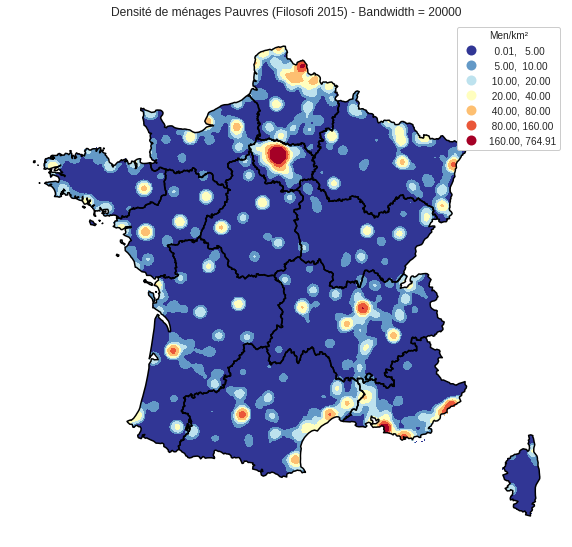

In [273]:
bins = [5, 10, 20, 40, 80, 160]
ax = liss_france.plot('Men_pauv',
                      scheme='user_defined', 
                      classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'RdYlBu_r', 
                      legend=True,
                      legend_kwds={'loc': 'best', 'frameon':True, 'framealpha':1, 'title':'Men/km²'} )
region.geometry.boundary.plot(color="black", ax=ax)
ax.set_axis_off()
ax.set_title('Densité de ménages Pauvres (Filosofi 2015) - Bandwidth = 20000')

### L'Ile de France

In [ ]:
liss_Paris_extra.Men_pauv = liss_Paris_extra.Men_pauv * 4

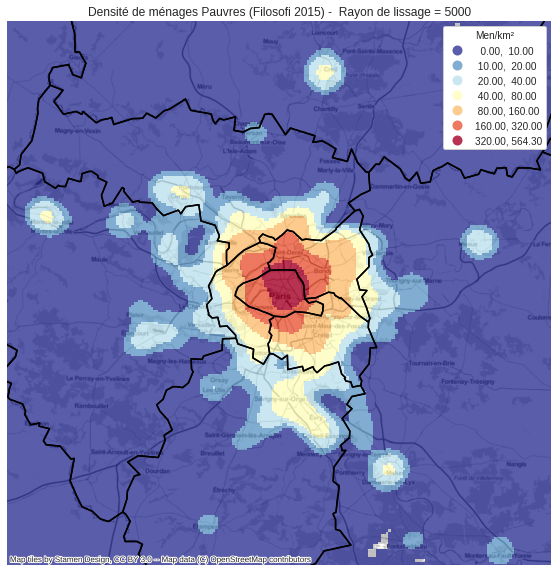

In [275]:
bins = [10, 20, 40, 80, 160, 320]
ax = liss_Paris_extra.plot('Men_pauv', 
                      #scheme = 'Quantiles',     
                      scheme='user_defined', 
                      classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'RdYlBu_r', 
                      legend=True,
                      alpha=0.8,
                      legend_kwds={'loc': 'best', 'frameon':True, 'framealpha':1, 'title':'Men/km²'}    )
departement.geometry.boundary.plot(color="black", ax=ax)
ax.set_axis_off()
ax.set_xlim((651935-55000, 651935+55000))
ax.set_ylim((6862339-55000, 6862339+55000))
ax.set_title('Densité de ménages Pauvres (Filosofi 2015) -  Rayon de lissage = 5000')
cx.add_basemap(ax, crs=liss_Paris_extra.crs.to_string(),source=cx.providers.Stamen.Toner)

### Paris

In [203]:
liss_Paris_intra.Men_pauv = liss_Paris_intra.Men_pauv * 100

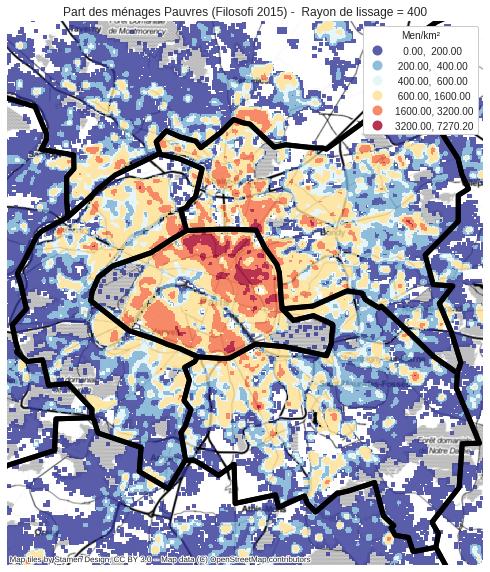

In [274]:
bins = [200, 400, 600, 1600, 3200]
ax = liss_Paris_intra.plot('Men_pauv', 
                      #scheme = 'Quantiles',
                      scheme='user_defined', 
                      classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'RdYlBu_r', 
                      legend=True, 
                      alpha=0.8,
                      legend_kwds={'loc': 'best', 'frameon':True, 'framealpha':1, 'title':'Men/km²'})
departement.geometry.boundary.plot(color="Black", ax=ax, linewidth=5)
ax.set_axis_off()
ax.set_xlim((651935-15000, 651935+20000))
ax.set_ylim((6862339-20000, 6862339+20000))
ax.set_title('Part des ménages Pauvres (Filosofi 2015) -  Rayon de lissage = 400')
cx.add_basemap(ax, crs=liss_Paris_intra.crs.to_string(),source=cx.providers.Stamen.Toner)

Pour aller plus loin, on peut également représenter les revenus

In [294]:
liss_Paris_intra['snv'] = liss_Paris_intra['Ind_snv'] / liss_Paris_intra['Ind']

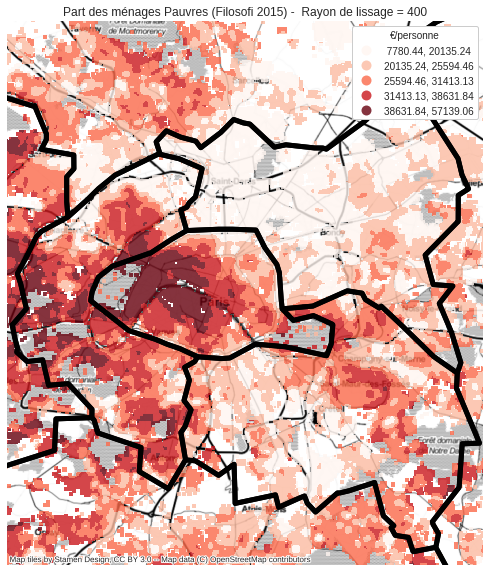

In [297]:
bins = [200, 400, 600, 1600, 3200]
ax = liss_Paris_intra.plot('snv', 
                      scheme = 'fisher_jenks_sampled',    
                      #scheme = 'Quantiles',     
                      #scheme='user_defined', 
                      #classification_kwds={'bins': bins}, 
                      figsize=(10,10), 
                      cmap = 'Reds', 
                      legend=True, 
                      alpha=0.8,
                      legend_kwds={'loc': 'best', 'frameon':True, 'framealpha':1, 'title':'€/personne'})
departement.geometry.boundary.plot(color="Black", ax=ax, linewidth=5)
ax.set_axis_off()
ax.set_xlim((651935-15000, 651935+20000))
ax.set_ylim((6862339-20000, 6862339+20000))
ax.set_title('Part des ménages Pauvres (Filosofi 2015) -  Rayon de lissage = 400')
cx.add_basemap(ax, crs=liss_Paris_intra.crs.to_string(),source=cx.providers.Stamen.Toner)

### Part cumulée des ménages pauvres de la petite couronne Parisienne mesurée à partir du centre de Paris

In [155]:
Men_couronne = Men[Men.Depcom.str.slice(0,2).isin(['75', '92', '93', '94'])].copy()

In [157]:
Men_couronne['distance'] = ((Men_couronne.x - 651935)**2 + (Men_couronne.y - 6862339)**2)**0.5

In [177]:
cumul = Men_couronne.groupby('distance', as_index=False)['Men_pauv', 'Men'].sum()
cumul = cumul.sort_values('distance')
cumul.Men_pauv = cumul.Men_pauv.cumsum() / Men_couronne.Men_pauv.sum() * 100
cumul.Men = cumul.Men.cumsum() / Men_couronne.Men.sum() * 100

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [196]:
df = pd.DataFrame({'x':[651935], 'y':[6862339]})
centre = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

In [211]:
cercle_5000 = centre.copy()
cercle_5000.geometry = cercle_5000.geometry.buffer(5000) 
cercle_7500 = centre.copy()
cercle_7500.geometry = cercle_7500.geometry.buffer(7500) 
cercle_10000 = centre.copy()
cercle_10000.geometry = cercle_10000.geometry.buffer(10000) 

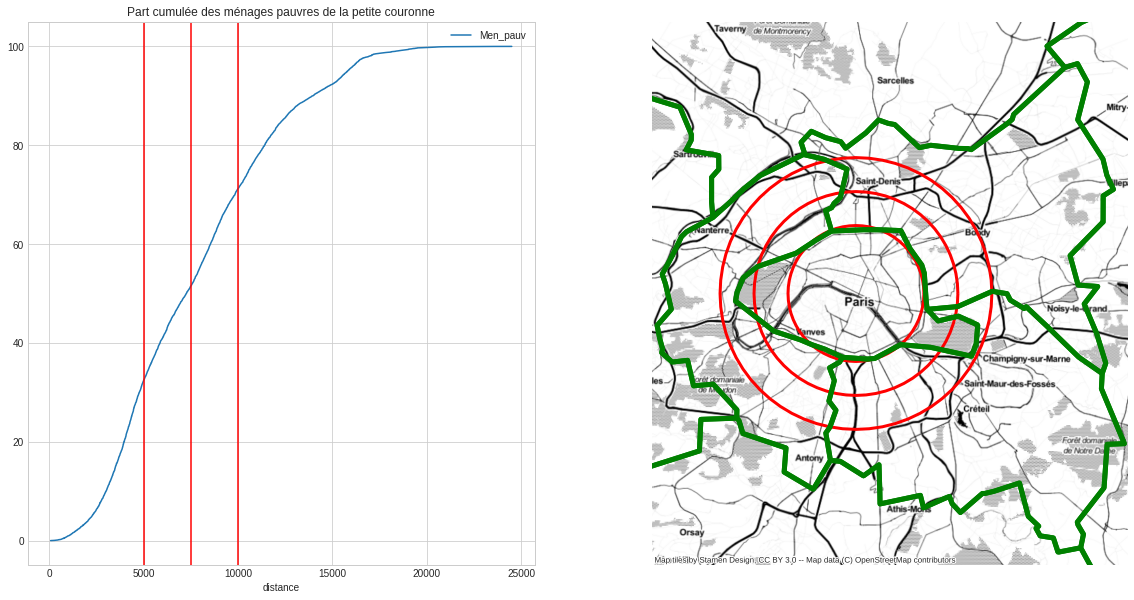

In [245]:
fig, axs = plt.subplots(ncols=2, figsize=(20,10))
cumul.plot.line('distance', 'Men_pauv', grid=True, ax=axs[0])
axs[0].axvline(x=5000, color='red')
axs[0].axvline(x=7500, color='red')
axs[0].axvline(x=10000, color='red')
axs[0].set_title('Part cumulée des ménages pauvres de la petite couronne')


cercle_5000.boundary.plot(color='red', ax=axs[1],linewidth=3)
cercle_10000.boundary.plot(color='red', ax=axs[1],linewidth=3)
cercle_7500.boundary.plot(color='red', ax=axs[1],linewidth=3)
departement.geometry.boundary.plot(color="green", ax=axs[1],linewidth=5)
axs[1].set_axis_off()
axs[1].set_xlim((651935-15000, 651935+20000))
axs[1].set_ylim((6862339-20000, 6862339+20000))
axs[1].set_title('')
cx.add_basemap(axs[1], crs=liss_Paris_intra.crs.to_string(),source=cx.providers.Stamen.Toner)

### Analyse des environnements 

In [280]:
env = btb.kernelSmoothing(Men_couronne[['Men', 'Men_pauv', 'x', 'y']], '2154', 100, 400,verbose=False)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [281]:
env['Part des ménages pauvres'] =  env['Men_pauv'] / env['Men'] * 100
env = env.sort_values('Part des ménages pauvres')

In [282]:
env['Part cumulée des ménages pauvres dans la petite couronne'] = env.Men_pauv.cumsum() / env.Men_pauv.sum() * 100

Text(0.5, 1.0, 'Part des ménages pauvres cumulée en fonction de la pauvreté de leur environnement')

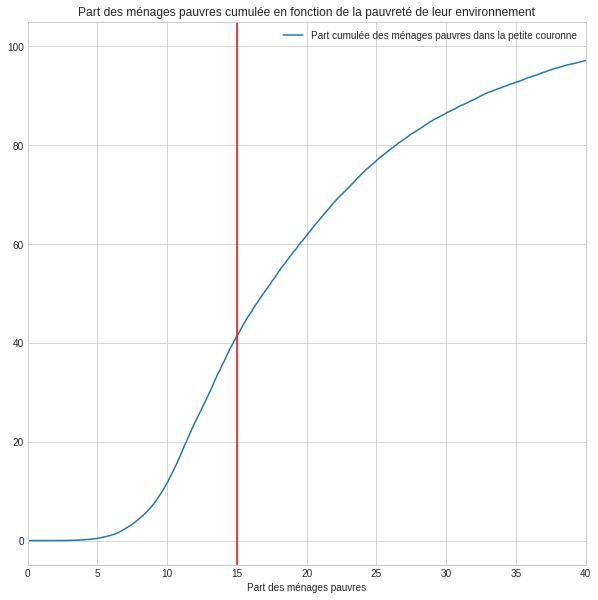

In [298]:
ax = env.plot.line('Part des ménages pauvres', 'Part cumulée des ménages pauvres dans la petite couronne', figsize=(10, 10))
ax.set_xlim((0, 40))
ax.axvline(x=15, color='red')
ax.set_title('Part des ménages pauvres cumulée en fonction de la pauvreté de leur environnement')